In [1]:
import datetime
import os
import glob
import gc
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib import colors

plt.style.use('science.mplstyle')
projectdir = '/glade/campaign/uwyo/wyom0112/berkeley/'

In [2]:
gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3']
variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',]

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian','proleptic_gregorian',]

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',]

savepath = '/glade/campaign/uwyo/wyom0112/berkeley/'
dir_meta = "/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/"
domains = ['d01', 'd02', 'd03','d04']
snowmaxkeys = {'d01':['cesm2_r11i1p1f1_ssp370_d01',
                     'mpi-esm1-2-lr_r7i1p1f1_ssp370_d01',
                     'cnrm-esm2-1_r1i1p1f2_ssp370_d01',
                     'ec-earth3-veg_r1i1p1f1_ssp370_d01',
                    'fgoals-g3_r1i1p1f1_ssp370_d01',
                     'ukesm1-0-ll_r2i1p1f2_ssp370_d01',
                     'canesm5_r1i1p2f1_ssp370_d01', 
                     'access-cm2_r5i1p1f1_ssp370_d01',
                     'ec-earth3_r1i1p1f1_ssp370_d01',],
               'd02':['cesm2_r11i1p1f1_ssp370_d02',
                     'mpi-esm1-2-lr_r7i1p1f1_ssp370_d02',
                     'cnrm-esm2-1_r1i1p1f2_ssp370_d02',
                    'ec-earth3-veg_r1i1p1f1_ssp370_d02',
                      'fgoals-g3_r1i1p1f1_ssp370_d02',
                      'ukesm1-0-ll_r2i1p1f2_ssp370_d02',
                      'canesm5_r1i1p2f1_ssp370_d02',
                      'access-cm2_r5i1p1f1_ssp370_d02',
                      'ec-earth3_r1i1p1f1_ssp370_d02'],
               'd03':[ 'ec-earth3-veg_r1i1p1f1_ssp370_d03', ],
               'd04': ['ec-earth3-veg_r1i1p1f1_ssp370_d04',]
              }


In [3]:
coords1 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d01')
coords2 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d02')
coords4 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d04')
coords3 = xr.open_dataset('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/wrfinput_d03')
coords_dict = {'d01': coords1, 
               'd02': coords2,
               'd03': coords3,
               'd04': coords4}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('epsg:4269')
states = gpd.read_file('/glade/work/mcowherd/data/cb_2018_us_state_5m.shp').to_crs('epsg:4269')
provinces = gpd.read_file('/glade/work/mcowherd/data/lpr_000b16a_e.shp').to_crs('epsg:4269')
polbd = gpd.read_file('/glade/work/mcowherd/data/ne_10m_admin_1_states_provinces.shp')
gc.collect()

0

In [4]:
# what years are we going to use?
inc = 30
y1 = 1980
y2 = y1 + inc
y3 = 2030
y4 = y3 + inc
y5 = 2070
y6 = y5 + inc

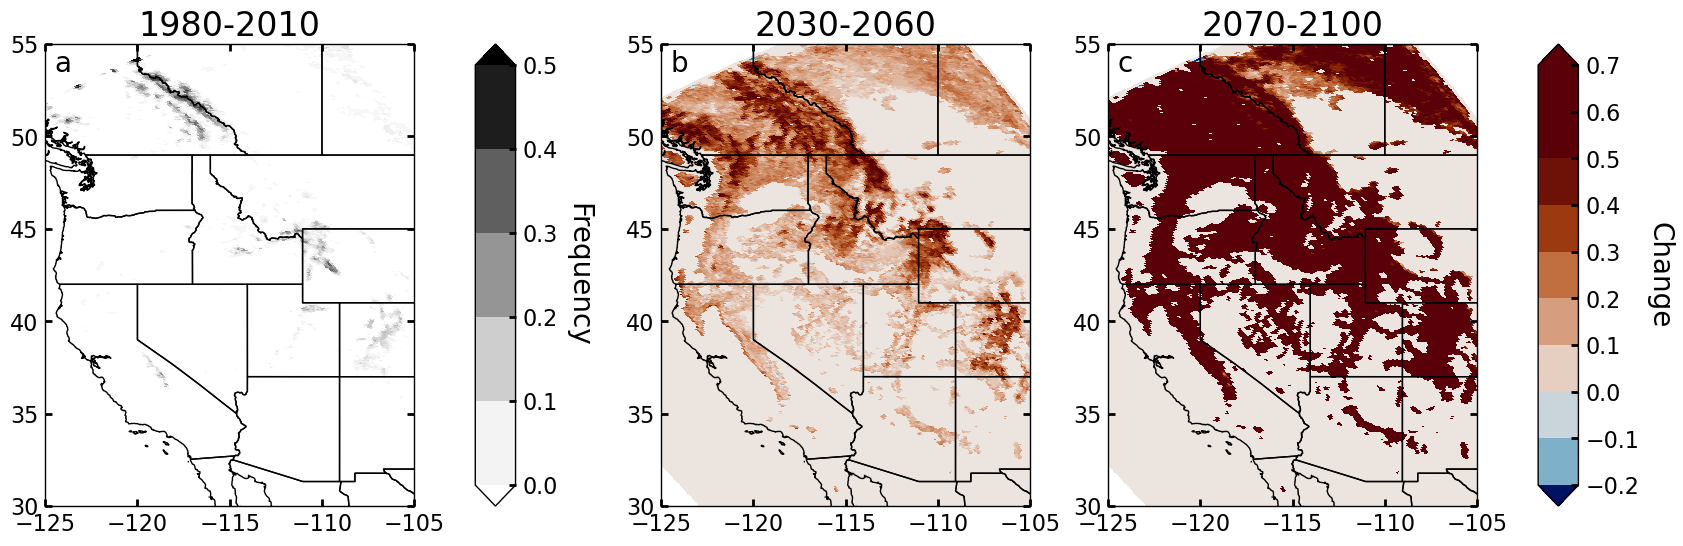

In [60]:
## 9-km only ## 
## Frequency calcs ##
import cmcrameri.cm as ccm
num_steps = 9
cmap = ccm.vik
new_cmap = colors.LinearSegmentedColormap.from_list('truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))

mosaic = """
AB.CDE
"""

bounds = {'d02': [[-125,-105],[30,55]],
          'd03': [[-125,-117],[33,45]],
          'd04': [[-115,-105],[39,47]]}

fig = plt.figure(figsize = (20,6))
axs = fig.subplot_mosaic(mosaic, width_ratios = [1,0.1,0.1,1,1,0.1])

i = 0
domains = ['d02']
for domain in domains:
    maxsnow = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'__xarray_dataarray_variable__':'swe'})
    swemask = maxsnow.sel(time = slice(maxsnow.time[0], maxsnow.time[20])).mean(dim = 'time').mean(dim = 'gcm').swe > 40
    swemask = swemask.rename({'lat2d':'lat', 'lon2d':'lon'})
    coords = coords_dict[domain]
    landmask = coords['LANDMASK'][0].rename({'south_north':'lat', 'west_east':'lon'})
    lat = coords['XLAT'][0]
    lon = coords['XLONG'][0]
    fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_*_{domain}_BC.nc')
    categs = xr.open_mfdataset(fns, combine = 'nested', concat_dim = 'gcm').where(landmask).where(swemask)
    base = categs.sel(year = slice(y1,y2)).mean(dim = 'gcm').swei
    swei_adj = categs.mean(dim = 'gcm').swei - np.nanmean(base)

    swei_cond = swei_adj <= -0.8
    
    ax1 = axs[chr(65 + i)]
    
    base_freq =  swei_cond.sel(year = slice(y1,y2)).mean(dim = 'year')
    cb1 = ax1.pcolormesh(lon, lat, base_freq, vmin = 0, vmax = 0.5, cmap = 'Greys')
    ax2 = axs[chr(65 + i + 2)]
    mid_freq =  swei_cond.sel(year = slice(y3,y4)).mean(dim = 'year')
    diff2 = mid_freq - base_freq

    ax2.pcolormesh(lon, lat, diff2, vmin = -.5, vmax = .5, cmap = new_cmap)
    ax3 = axs[chr(65 + i + 3)]
    eoc_freq =  swei_cond.sel(year = slice(y5,y6)).mean(dim = 'year')
    diff3 = eoc_freq - base_freq
    cb3 = ax3.pcolormesh(lon,lat, diff3, vmin = -.5, vmax = .5, cmap = new_cmap)
    for ax in [ax1, ax2, ax3]:
        polbd.boundary.plot(ax=ax, color = 'k', linestyle= '-')
        ax.set_xlim(bounds[domain][0])
        ax.set_ylim(bounds[domain][1])
    if i ==0 :
        bounds1 = np.linspace(0, 0.5,6)
        cbar1 = plt.colorbar(cb1, axs['B'], pad= -0.2, orientation='vertical', ticks = [round(b,2) for b in bounds1], boundaries = bounds1,
                         extend='both')
        bounds3 = np.linspace(-0.2, .7, 10 )
        cbar3 = plt.colorbar(cb3, axs['E'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds3],boundaries = bounds3,
                         extend='both')
    i+=1
    gc.collect()
    
## 
cbar1.set_label('Frequency',rotation=270, labelpad = 25)
cbar3.set_label('Change',rotation=270, labelpad = 25)

axs['A'].set_title(f'{y1}-{y2}')
axs['C'].set_title(f'{y3}-{y4}')
axs['D'].set_title(f'{y5}-{y6}')
for i,label in enumerate(['A','C','D']):
    axs[label].text(-124.5, 53.5, chr(i + 97))

plt.savefig('../figures/fig_sweimap.jpg', dpi = 400)
plt.show()


In [52]:
base_cond = (base - np.nanmean(base)) <= -0.8

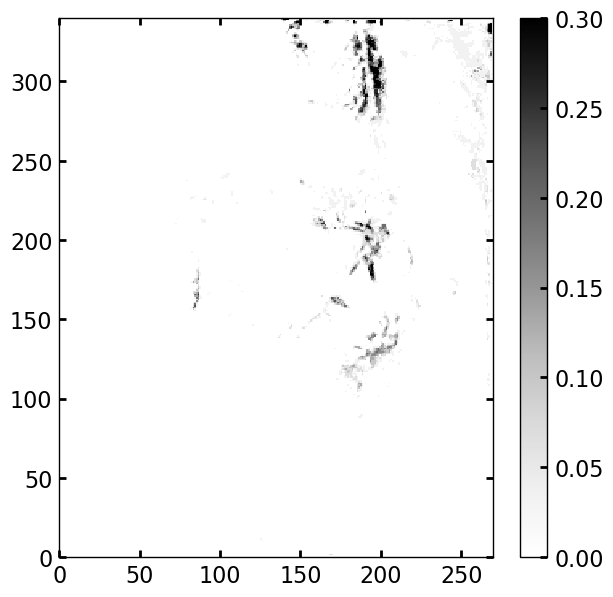

In [57]:
plt.pcolormesh(base_cond.mean(dim = 'year'), vmin = 0 , vmax = 0.3, cmap = 'Greys')
plt.colorbar()

In [22]:
swei_adj = categs.mean(dim = 'gcm').swei - base.mean(dim ='year')
swei_cond = swei_adj <= -0.8

In [41]:
swei_cond.shape

(121, 340, 270)

In [39]:
swei_cond.values

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

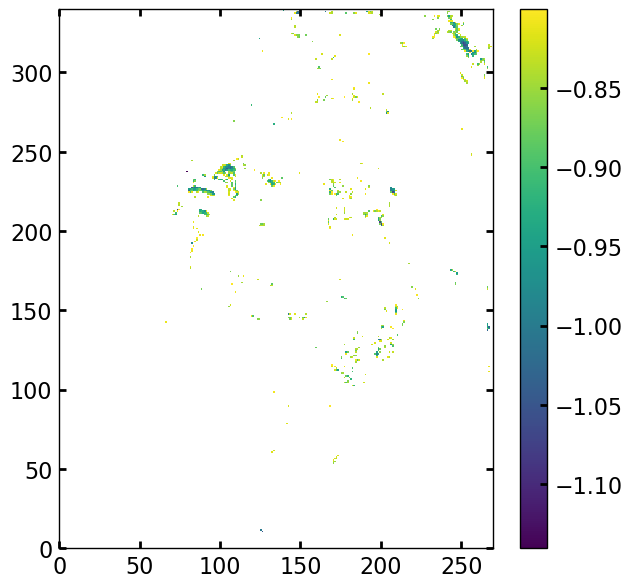

In [38]:
plt.pcolormesh(swei_adj.sel(year = slice(1980,2010)).where(swei_cond).mean(dim = 'year'))
plt.colorbar()

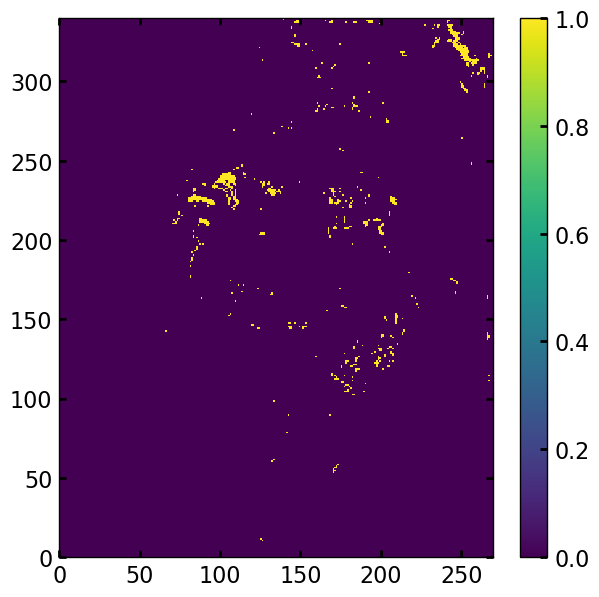

In [27]:
plt.pcolormesh(swei_cond.sel(year = slice(1980,2010)).sum(dim = 'year'), vmin = 0, vmax = 1)
plt.colorbar()

(array([  2.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   2.,   2.,   1.,
          9.,   4.,   5.,   6.,  10.,  10.,   7.,   8.,  17.,  16.,  37.,
         17.,  41.,  47.,  45.,  47.,  56.,  96.,  97., 143., 114., 164.,
        233., 234., 300., 294., 409., 428., 535., 445., 687., 760., 785.,
        837., 694., 960., 911., 978., 982., 696., 921., 812., 850., 573.,
        745., 623., 625., 603., 387., 470., 408., 367., 245., 289., 246.,
        208., 197., 123., 142., 113., 116.,  62.,  73.,  68.,  44.,  49.,
         25.,  26.,  19.,  17.,  12.,  12.,   7.,   8.,   7.,   6.,   3.,
          5.,   1.,   2.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([-4.54833304e-16, -4.44877110e-16, -4.34920916e-16, -4.24964723e-16,
        -4.15008529e-16, -4.05052336e-16, -3.95096142e-16, -3.85139949e-16,
        -3.75183755e-16, -3.65227561e-16, -3.55271368e-16, -3.45315174e-16,
        -3.35358981e-16, -3.25402787e-16, -3.15446594e-16, -3.05490400e-16,
        -2.955

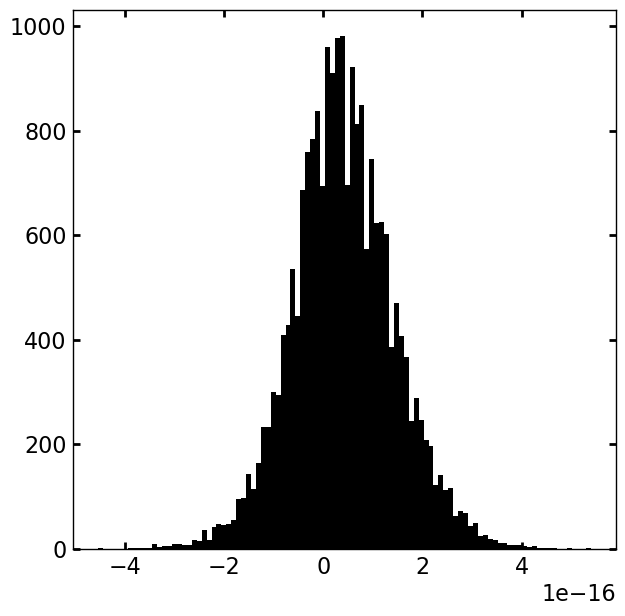

In [14]:
plt.hist(base_freq.values.flatten(), bins = 100)
plt.show()

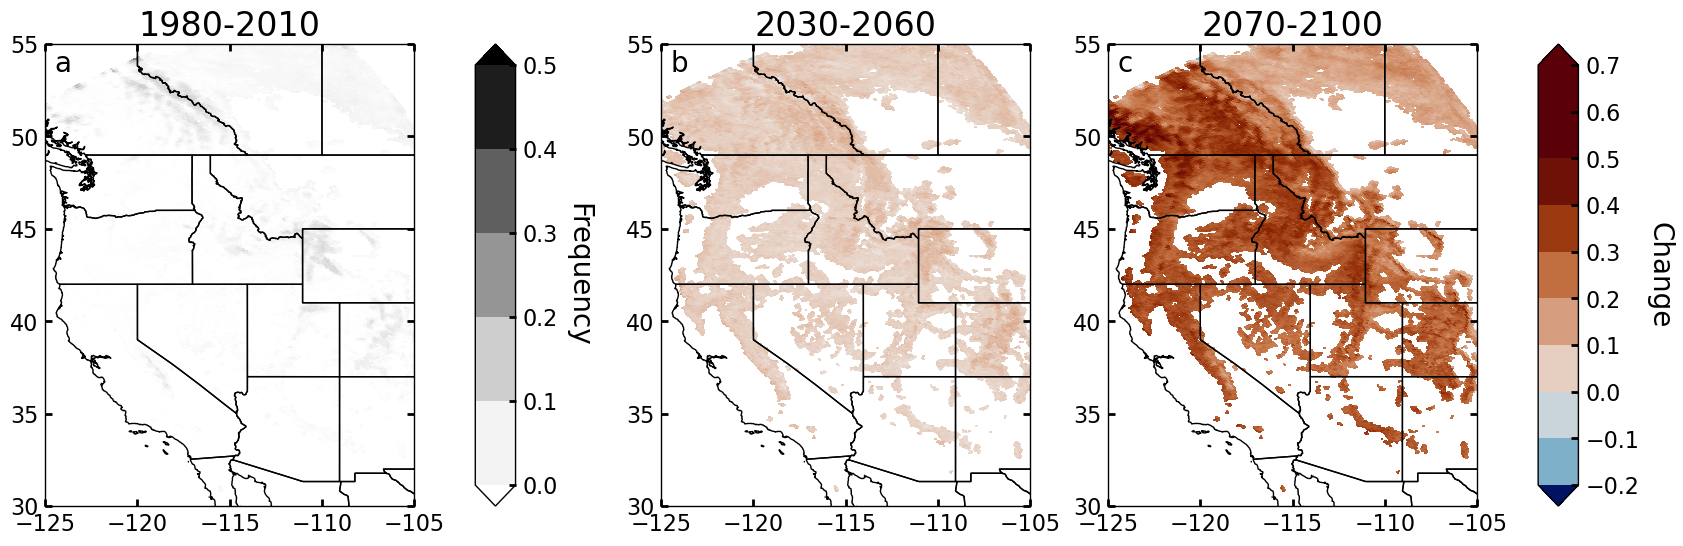

In [5]:
## 9-km only ## 
## Frequency calcs ##
import cmcrameri.cm as ccm
num_steps = 9
cmap = ccm.vik
new_cmap = colors.LinearSegmentedColormap.from_list('truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))

mosaic = """
AB.CDE
"""

bounds = {'d02': [[-125,-105],[30,55]],
          'd03': [[-125,-117],[33,45]],
          'd04': [[-115,-105],[39,47]]}

fig = plt.figure(figsize = (20,6))
axs = fig.subplot_mosaic(mosaic, width_ratios = [1,0.1,0.1,1,1,0.1])

i = 0
domains = ['d02']
for domain in domains:
    maxsnow = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'__xarray_dataarray_variable__':'swe'})
    swemask = maxsnow.sel(time = slice(maxsnow.time[0], maxsnow.time[20])).mean(dim = 'time').mean(dim = 'gcm').swe > 40
    swemask = swemask.rename({'lat2d':'lat', 'lon2d':'lon'})
    coords = coords_dict[domain]
    landmask = coords['LANDMASK'][0].rename({'south_north':'lat', 'west_east':'lon'})
    lat = coords['XLAT'][0]
    lon = coords['XLONG'][0]
    fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_*_{domain}_BC.nc')
    categs = xr.open_mfdataset(fns, combine = 'nested', concat_dim = 'gcm').where(landmask).where(swemask)
    base = categs.sel(year = slice(y1,y2)).mean(dim = 'year').mean(dim = 'gcm').swei
    swei_adj = categs.mean(dim = 'year').mean(dim = 'gcm').swei - base

    
    ax1 = axs[chr(65 + i)]
    base_freq =  categs.sel(year = slice(y1,y2)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    cb1 = ax1.pcolormesh(lon, lat, base_freq, vmin = 0, vmax = 0.5, cmap = 'Greys')
    ax2 = axs[chr(65 + i + 2)]
    mid_freq =  categs.sel(year = slice(y3,y4)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    diff2 = mid_freq - base_freq

    ax2.pcolormesh(lon, lat, diff2, vmin = -.5, vmax = .5, cmap = new_cmap)
    ax3 = axs[chr(65 + i + 3)]
    eoc_freq =  categs.sel(year = slice(y5,y6)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    diff3 = eoc_freq - base_freq
    cb3 = ax3.pcolormesh(lon,lat, diff3, vmin = -.5, vmax = .5, cmap = new_cmap)
    for ax in [ax1, ax2, ax3]:
        polbd.boundary.plot(ax=ax, color = 'k', linestyle= '-')
        ax.set_xlim(bounds[domain][0])
        ax.set_ylim(bounds[domain][1])
    if i ==0 :
        bounds1 = np.linspace(0, 0.5,6)
        cbar1 = plt.colorbar(cb1, axs['B'], pad= -0.2, orientation='vertical', ticks = [round(b,2) for b in bounds1], boundaries = bounds1,
                         extend='both')
        bounds3 = np.linspace(-0.2, .7, 10 )
        cbar3 = plt.colorbar(cb3, axs['E'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds3],boundaries = bounds3,
                         extend='both')
    i+=1
    gc.collect()
    
## 
cbar1.set_label('Frequency',rotation=270, labelpad = 25)
cbar3.set_label('Change',rotation=270, labelpad = 25)

axs['A'].set_title(f'{y1}-{y2}')
axs['C'].set_title(f'{y3}-{y4}')
axs['D'].set_title(f'{y5}-{y6}')
for i,label in enumerate(['A','C','D']):
    axs[label].text(-124.5, 53.5, chr(i + 97))

plt.savefig('../figures/fig_sweimap.jpg', dpi = 400)
plt.show()


/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


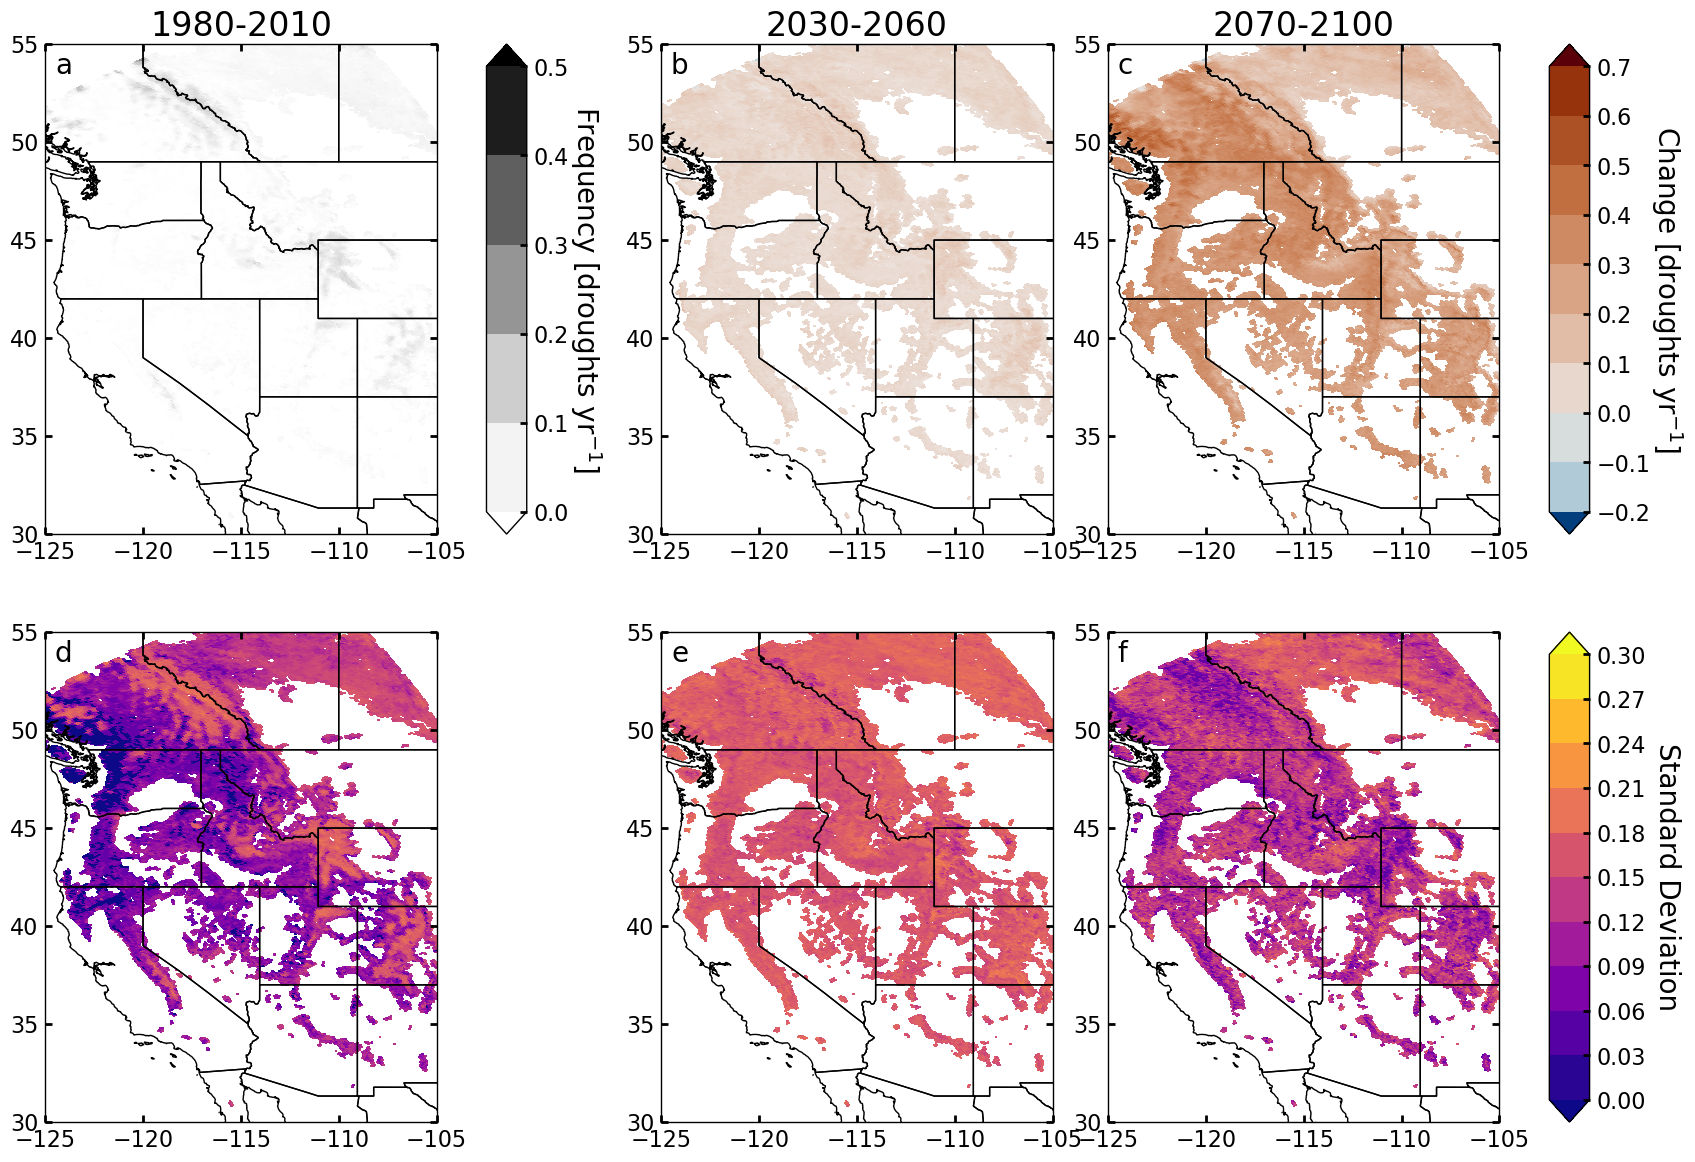

In [6]:
## 9-km only ## 
num_steps = 9
cmap = ccm.vik
new_cmap = colors.LinearSegmentedColormap.from_list('truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))



mosaic = """
AB.CDE
F..GHI
"""

bounds = {'d02': [[-125,-105],[30,55]],
          'd03': [[-125,-117],[33,45]],
          'd04': [[-115,-105],[39,47]]}

fig = plt.figure(figsize = (20,14))
axs = fig.subplot_mosaic(mosaic, width_ratios = [1,0.1,0.1,1,1,0.1])

i = 0
domains = ['d02']
for domain in domains:
    maxsnow = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'__xarray_dataarray_variable__':'swe'})
    swemask = maxsnow.sel(time = slice(maxsnow.time[0], maxsnow.time[20])).mean(dim = 'time').mean(dim = 'gcm').swe > 40
    swemask = swemask.rename({'lat2d':'lat', 'lon2d':'lon'})
    coords = coords_dict[domain]
    landmask = coords['LANDMASK'][0].rename({'south_north':'lat', 'west_east':'lon'})
    lat = coords['XLAT'][0]
    lon = coords['XLONG'][0]
    fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_*_{domain}_BC.nc')
    categs = xr.open_mfdataset(fns, combine = 'nested', concat_dim = 'gcm').where(landmask).where(swemask)
    ax1 = axs[chr(65 + i)]
    ax12 = axs[chr(65 + i + 5)]
    sd_mask =  categs.sel(year = slice(y1,y2)).swei_cond
    base_freq =  categs.sel(year = slice(y1,y2)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    base_dev = categs.sel(year = slice(y1,y2)).swei_cond.std(dim = 'gcm').std(dim = 'year')
    cb1 = ax1.pcolormesh(lon, lat, base_freq, vmin = 0, vmax = 0.5, cmap = 'Greys')
    cb12 = ax12.pcolormesh(lon, lat, base_dev, vmin = 0, vmax = 0.3, cmap = 'plasma')
    ax2 = axs[chr(65 + i + 2)]
    ax22 = axs[chr(65 + i + 6)]
    sd_mask =  categs.sel(year = slice(y3,y4)).swei_cond
    mid_freq =  categs.sel(year = slice(y3,y4)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    diff2 = mid_freq - base_freq
    ax2.pcolormesh(lon, lat, diff2, vmin = -.9, vmax = .9, cmap = new_cmap)
    mid_dev = categs.sel(year = slice(y3,y4)).swei_cond.std(dim = 'gcm').std(dim = 'year')
    cb22 = ax22.pcolormesh(lon, lat, mid_dev, cmap = 'plasma', vmin = 0, vmax = 0.3)
    ax3 = axs[chr(65 + i + 3)]
    ax32 = axs[chr(65 + i + 7)]
    sd_mask =  categs.sel(year = slice(y5,y6)).swei_cond
    eoc_freq =  categs.sel(year = slice(y5,y6)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    eoc_dev = categs.sel(year = slice(y5,y6)).swei_cond.std(dim = 'gcm').std(dim = 'year')
    diff3 = eoc_freq - base_freq
    cb3 = ax3.pcolormesh(lon,lat, diff3, vmin = -.9, vmax = .9, cmap = new_cmap)
    cb32 = ax32.pcolormesh(lon, lat, eoc_dev, cmap = 'plasma', vmin = 0 , vmax = 0.3)
    for ax in [ax1, ax2, ax3, ax12, ax22, ax32]:
        polbd.boundary.plot(ax=ax, color = 'k', linestyle= '-')
        ax.set_xlim(bounds[domain][0])
        ax.set_ylim(bounds[domain][1])
    if i ==0 :
        bounds1 = np.linspace(0, 0.5,6)
        cbar1 = plt.colorbar(cb1, axs['B'], pad= -0.2, orientation='vertical', ticks = [round(b,2) for b in bounds1], boundaries = bounds1,
                         extend='both')
        bounds3 = np.linspace(-0.2, .7, 10 )
        cbar3 = plt.colorbar(cb3, axs['E'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds3],boundaries = bounds3,
                         extend='both')
        bounds4 = np.linspace(0,0.3,11)
        cbar4 = plt.colorbar(cb12, axs['I'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds4],boundaries = bounds4,
                         extend='both')
    i+=1
    gc.collect()
    
## 
cbar1.set_label('Frequency [droughts yr$^{-1}$]',rotation=270, labelpad = 25)
cbar3.set_label(r'Change [droughts yr$^{-1}$]',rotation=270, labelpad = 25)
cbar4.set_label('Standard Deviation', rotation = 270, labelpad = 25)

axs['A'].set_title(f'{y1}-{y2}')
axs['C'].set_title(f'{y3}-{y4}')
axs['D'].set_title(f'{y5}-{y6}')

for i,label in enumerate(['A','C','D','F','G','H']):
    axs[label].text(-124.5, 53.5, chr(i + 97))
plt.savefig('../figures/swei_freq_var.jpg', dpi = 400)

plt.show()


/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/glade/u/home/mcowherd/.conda/envs/fos/lib/python3.10/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


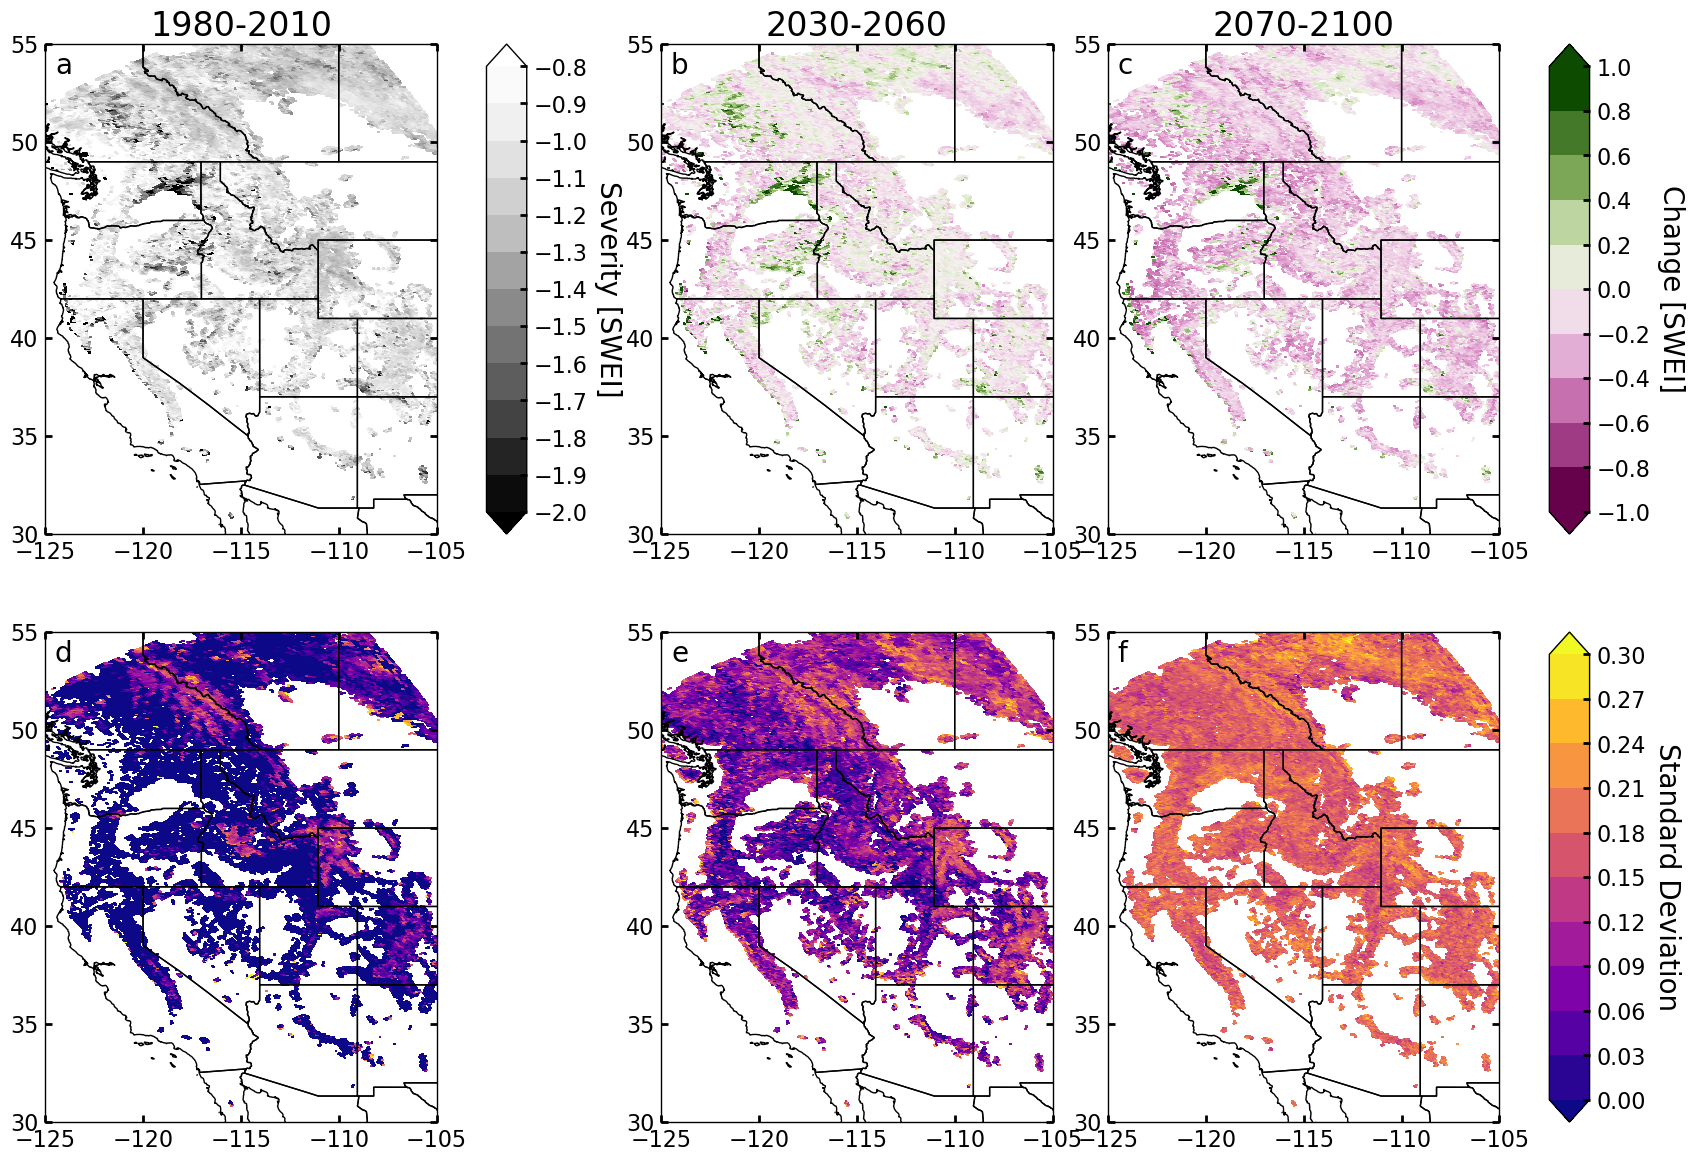

In [7]:
## 9-km only ## 

num_steps = 9
cmap = ccm.bam
new_cmap = colors.LinearSegmentedColormap.from_list('truncated_cmap', cmap(np.linspace(0.0, 1.0, num_steps)))


mosaic = """
AB.CDE
F..GHI
"""

bounds = {'d02': [[-125,-105],[30,55]],
          'd03': [[-125,-117],[33,45]],
          'd04': [[-115,-105],[39,47]]}

fig = plt.figure(figsize = (20,14))
axs = fig.subplot_mosaic(mosaic, width_ratios = [1,0.1,0.1,1,1,0.1])

i = 0
domains = ['d02']
for domain in domains:
    maxsnow = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'__xarray_dataarray_variable__':'swe'})
    swemask = maxsnow.sel(time = slice(maxsnow.time[0], maxsnow.time[20])).mean(dim = 'time').mean(dim = 'gcm').swe > 40
    swemask = swemask.rename({'lat2d':'lat', 'lon2d':'lon'})
    coords = coords_dict[domain]
    landmask = coords['LANDMASK'][0].rename({'south_north':'lat', 'west_east':'lon'})
    lat = coords['XLAT'][0]
    lon = coords['XLONG'][0]
    fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_*_{domain}_BC.nc')
    categs = xr.open_mfdataset(fns, combine = 'nested', concat_dim = 'gcm').where(landmask).where(swemask)
    ax1 = axs[chr(65 + i)]
    ax12 = axs[chr(65 + i + 5)]
    sd_mask =  categs.sel(year = slice(y1,y2)).swei_cond
    base_freq =  categs.sel(year = slice(y1,y2)).where(sd_mask).swei.mean(dim = 'gcm').mean(dim = 'year')
    base_dev = categs.sel(year = slice(y1,y2)).where(sd_mask).swei.std(dim = 'gcm').std(dim = 'year')
    cb1 = ax1.pcolormesh(lon, lat, base_freq, vmin = -2, vmax = -0.8, cmap = 'Greys_r')
    cb12 = ax12.pcolormesh(lon, lat, base_dev, vmin = 0, vmax = 0.3, cmap = 'plasma')

    ax2 = axs[chr(65 + i + 2)]
    ax22 = axs[chr(65 + i + 6)]
    sd_mask =  categs.sel(year = slice(y3,y4)).swei_cond
    mid_freq = categs.sel(year = slice(y3,y4)).where(sd_mask).swei.mean(dim = 'gcm').mean(dim = 'year')
    diff2 = mid_freq - base_freq
    ax2.pcolormesh(lon, lat, diff2, vmin = -.9, vmax = .9, cmap = new_cmap)
    mid_dev = categs.sel(year = slice(y3,y4)).where(sd_mask).swei.std(dim = 'gcm').std(dim = 'year')
    cb22 = ax22.pcolormesh(lon, lat, mid_dev, cmap = 'plasma', vmin = 0, vmax = 0.3)
    ax3 = axs[chr(65 + i + 3)]
    ax32 = axs[chr(65 + i + 7)]
    sd_mask =  categs.sel(year = slice(y5,y6)).swei_cond
    eoc_freq =  categs.sel(year = slice(y5,y6)).where(sd_mask).swei.mean(dim = 'gcm').mean(dim = 'year')
    eoc_dev = categs.sel(year = slice(y5,y6)).where(sd_mask).swei.std(dim = 'gcm').std(dim = 'year')
    diff3 = eoc_freq - base_freq
    cb3 = ax3.pcolormesh(lon,lat, diff3, vmin = -.9, vmax = .9, cmap = new_cmap)
    cb32 = ax32.pcolormesh(lon, lat, eoc_dev, cmap = 'plasma', vmin = 0 , vmax = 0.3)
    for ax in [ax1, ax2, ax3, ax12, ax22, ax32]:
        polbd.boundary.plot(ax=ax, color = 'k', linestyle= '-')
        ax.set_xlim(bounds[domain][0])
        ax.set_ylim(bounds[domain][1])
    if i ==0 :
        bounds1 = np.linspace(-2, -0.8,13)
        cbar1 = plt.colorbar(cb1, axs['B'], pad= -0.2, orientation='vertical', ticks = [round(b,2) for b in bounds1], boundaries = bounds1,
                         extend='both')
        bounds3 = np.linspace(-1, 1, 11 )
        cbar3 = plt.colorbar(cb3, axs['E'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds3],boundaries = bounds3,
                         extend='both')
        bounds4 = np.linspace(0,0.3,11)
        cbar4 = plt.colorbar(cb12, axs['I'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds4],boundaries = bounds4,
                         extend='both')
    i+=1
    gc.collect()
    
## 
cbar1.set_label('Severity [SWEI]',rotation=270, labelpad = 25)
cbar3.set_label('Change [SWEI]',rotation=270, labelpad = 25)
cbar4.set_label('Standard Deviation', rotation = 270, labelpad = 25)

axs['A'].set_title(f'{y1}-{y2}')
axs['C'].set_title(f'{y3}-{y4}')
axs['D'].set_title(f'{y5}-{y6}')

for i,label in enumerate(['A','C','D','F','G','H']):
    axs[label].text(-124.5, 53.5, chr(i + 97))
plt.savefig('../figures/swei_sev.jpg', dpi = 400)

plt.show()


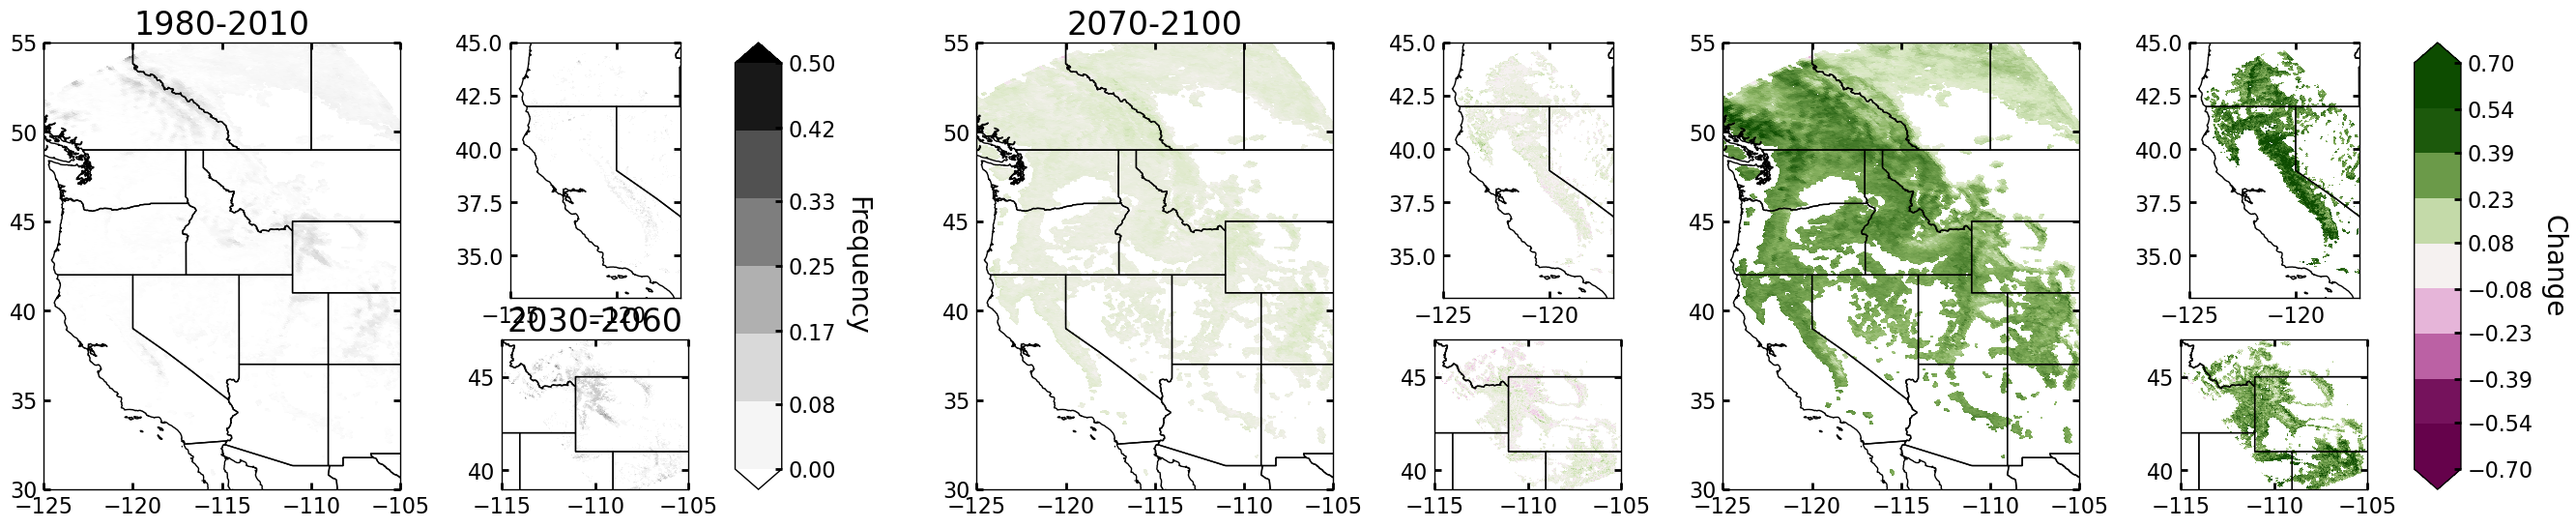

In [8]:
mosaic = """
ABJ.DEGHK
ACJ.DFGIK
"""

bounds = {'d02': [[-125,-105],[30,55]],
          'd03': [[-125,-117],[33,45]],
          'd04': [[-115,-105],[39,47]]}

fig = plt.figure(figsize = (33,6))
axs = fig.subplot_mosaic(mosaic,  height_ratios=[1.7,1], width_ratios = [1,0.4,0.1,0.1,1,0.4,1,0.4,0.1])

i = 0
domains = ['d02', 'd03', 'd04']
for domain in domains:
    maxsnow = xr.open_dataset(f'/glade/campaign/uwyo/wyom0112/berkeley/allsnowmax_BC_{domain}.nc').rename({'__xarray_dataarray_variable__':'swe'})
    swemask = maxsnow.sel(time = slice(maxsnow.time[0], maxsnow.time[20])).mean(dim = 'time').mean(dim = 'gcm').swe > 40
    swemask = swemask.rename({'lat2d':'lat', 'lon2d':'lon'})
    coords = coords_dict[domain]
    landmask = coords['LANDMASK'][0].rename({'south_north':'lat', 'west_east':'lon'})
    lat = coords['XLAT'][0]
    lon = coords['XLONG'][0]
    fns = glob.glob(f'/glade/campaign/uwyo/wyom0112/berkeley/categs_snow_*_{domain}_BC.nc')
    categs = xr.open_mfdataset(fns, combine = 'nested', concat_dim = 'gcm').where(landmask).where(swemask)
    ax1 = axs[chr(65 + i)]
    base_freq =  categs.sel(year = slice(y1,y2)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    cb1 = ax1.pcolormesh(lon, lat, base_freq, vmin = 0, vmax = 0.5, cmap = 'Greys')
    ax2 = axs[chr(65 + i + 3)]
    mid_freq =  categs.sel(year = slice(y3,y4)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    diff2 = mid_freq - base_freq

    ax2.pcolormesh(lon, lat, diff2, vmin = -.5, vmax = .5, cmap = new_cmap)
    ax3 = axs[chr(65 + i + 6)]
    eoc_freq =  categs.sel(year = slice(y5,y6)).mean(dim = 'year').mean(dim = 'gcm').swei_cond
    diff3 = eoc_freq - base_freq
    cb3 = ax3.pcolormesh(lon,lat, diff3, vmin = -.5, vmax = .5, cmap = new_cmap)
    for ax in [ax1, ax2, ax3]:
        # states.boundary.plot(ax=ax, color = 'k', linestyle = '-')
        # world.boundary.plot(ax=ax, color = 'k', linestyle = '-')
        polbd.boundary.plot(ax=ax, color = 'k', linestyle= '-')
        # provinces.boundary.plot(ax=ax, color = 'k', linestyle = '-')
        ax.set_xlim(bounds[domain][0])
        ax.set_ylim(bounds[domain][1])
    if i ==0 :
        bounds1 = np.linspace(0, 0.5,7)
        cbar1 = plt.colorbar(cb1, axs['J'], pad= -0.2, orientation='vertical', ticks = [round(b,2) for b in bounds1], boundaries = bounds1,
                         extend='both')
        bounds3 = np.linspace(-0.7, .7, num_steps +1 )
        cbar3 = plt.colorbar(cb3, axs['K'], pad=0., orientation='vertical',ticks = [round(b,2) for b in bounds3],boundaries = bounds3,
                         extend='both')
    i+=1
    gc.collect()
    
## 
cbar1.set_label('Frequency',rotation=270, labelpad = 25)
cbar3.set_label('Change',rotation=270, labelpad = 25)

axs['A'].set_title(f'{y1}-{y2}')
axs['C'].set_title(f'{y3}-{y4}')
axs['D'].set_title(f'{y5}-{y6}')
plt.savefig('../figures/fig_sweimap.jpg', dpi = 400)

plt.show()
